# 🔥 Mapping Wildfire Burn Severity with LeafMap & Python

Welcome to this hands-on mapping activity! In this notebook, you'll explore satellite imagery, calculate wildfire burn severity, and create your own interactive web map using open-source geospatial tools.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/asivitskis/EarthInquiryLab/blob/main/1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap/Wildfire_Burn_Severity_Mapping.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/asivitskis/EarthInquiryLab/main?filepath=1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap%2FWildfire_Burn_Severity_Mapping.ipynb)


## Learning Goals

By the end of this notebook, you will be able to:
- Understand and calculate the Normalized Burn Ratio (dNBR)
- Visualize burn severity using satellite imagery
- Interpret changes in vegetation using NIR/SWIR bands
- Use interactive maps to explore geographic data

<img src="Images/PTF_image.4.24.png" alt="My Image" width="600px">

<p><em>Image Credit: <a href="https://cowboystatedaily.com/2024/10/04/wyomings-pack-trail-elk-fires-are-top-wildfire-priorities-in-region/" target="_blank">Cowboy State Daily</a></em></p>


## 📦❓ Step 1. Ask Questions and Install Python Packages

The Pack Trail Fire was a forest fire incident that occured in the Bridger Teton National Forest from August to November, 2024 ([BTNF, 2024](https://gacc.nifc.gov/gbcc/dispatch/wy-tdc/home/sites/default/files/site-files/2024%20BT%20Annual%20Fire%20Report_Final.pdf)). The fire burned nearly 90,000 acres of montane and subalpine forest. Over 500 personel were involved in fire supression and management efforts, and multiple communities required evacuation. [Restoration efforts](https://www.fs.usda.gov/r04/bridger-teton/newsroom/releases/pack-trail-fire-restoration-begins-near-pinedale) by the US Fores Service are already underway.

So, **how severe was the Pack Trail Forest Fire?** In order to address this geo-inquiry question,
we’ll use geospatial technologies to help us answer the following points:
*   Where did this fire occur?
*   Did some areas of forest burn more severely than others?

The aim of this practical exercise is to generate a burn severity map for the area affected by the Pack Trail Fire. We can use a remote sensing procedure called the **Normalized Burn Ratio (NBR)** to identify areas that were burned by a fire and estimate burn severity. This process examines the ratio of near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths
measured by satellites. Calculating this ratio will help to document differences in reflectance characteristics between healthy vegetation and recently burned areas.

Our first step is to download some necessary python packages. Using the following codeblocks to import these packages:


In [1]:
# If running in Colab, uncomment:
#!pip install leafmap rasterio geopandas rioxarray localtileserver -q

import leafmap
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import rioxarray
import xarray as xr
import os

## 🌎 Step 2. Acquire Remote Sensing Data

We've prepared pre- and post-fire Landsat imagery for you. These files are hosted online for easy access. Use the following codeblock to download these images for analysis.

In [2]:
# Image paths
prefire_url = "https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/data/prefire_LC08_038030_20230925_utm13n.tif"
postfire_url = "https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/data/postfire_LC08_037030_20250806_utm13n.tif"

# Set Local filenames
prefire_file = "prefire.tif"
postfire_file = "postfire.tif"

# Download once
for url, fname in [(prefire_url, prefire_file), (postfire_url, postfire_file)]:
    if not os.path.exists(fname):
        import requests
        r = requests.get(url, stream=True)
        with open(fname, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

print("Satellite imagery succesfully downloaded!")


Satellite imagery succesfully downloaded!


## 📚 Step 3. Visualize Pre and Post Fire Imagery

Reviewing the data is an important step prior to analysis. Use the following code to plot the satellite images from before and after the
fire. Can you notice any areas of change between these two images? How does viewing different band combinations reveal different landscape patterns?

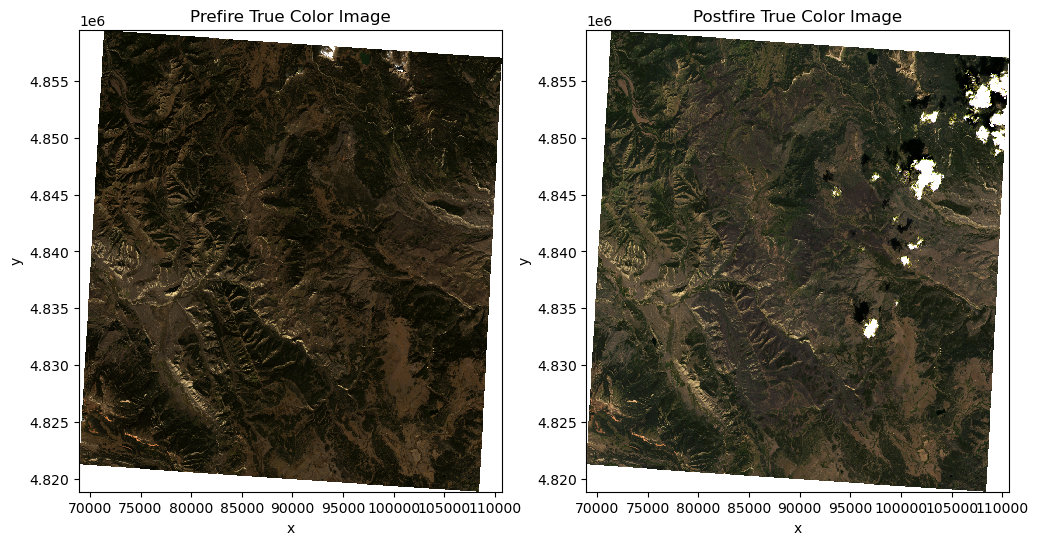

In [ ]:
# Load with rioxarray
prefire = rioxarray.open_rasterio(prefire_file, masked=True)
postfire = rioxarray.open_rasterio(postfire_file, masked=True)

# Visualize true color images to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
prefire.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3,ax=ax1)
ax1.set_title("Prefire True Color Image")
postfire.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3,ax=ax2)
ax2.set_title("Postfire True Color Image")
plt.show()

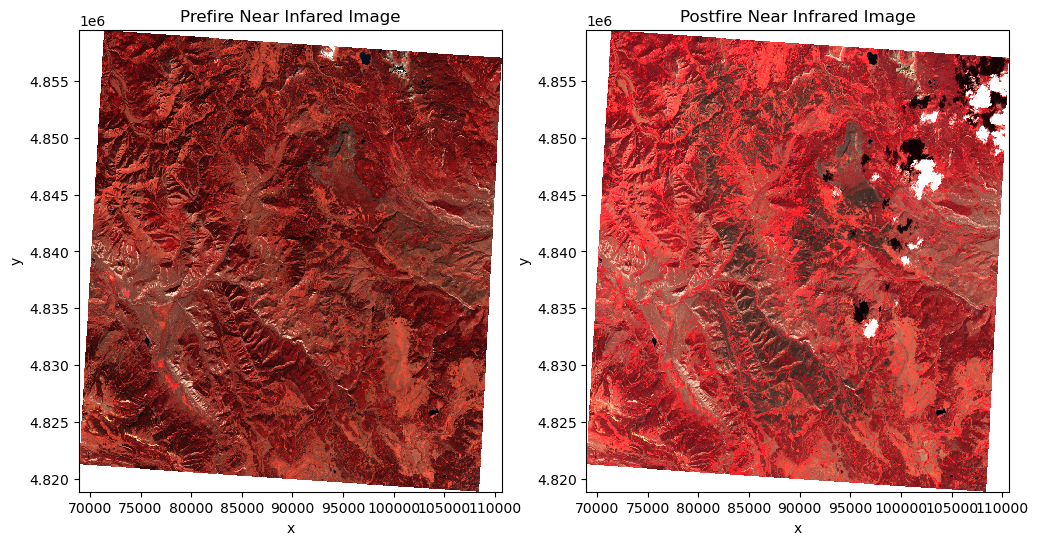

In [ ]:
# Visualize false color infrared images to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
prefire.sel(band=[5, 4, 3]).plot.imshow(vmin=0, vmax=0.3,ax=ax1)
ax1.set_title("Prefire Near Infared Image")
postfire.sel(band=[5, 4, 3]).plot.imshow(vmin=0, vmax=0.3,ax=ax2)
ax2.set_title("Postfire Near Infrared Image")
plt.show()

## 🔬 Step 4. Analyze Imagery and Calculate Change in Burn Severity (dNBR)

Now that we have our satellite imagery acquired, we can use simple indices to compare the two images and identify what areas have been changed.

Use the following code to compute the Normalized Burn Ratio (NBR) for both images, and then calculate how this measurement has changed before and after the fire (dNBR). Learn more about this process from the [United Nations SPIDER Reccomended Practice](https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

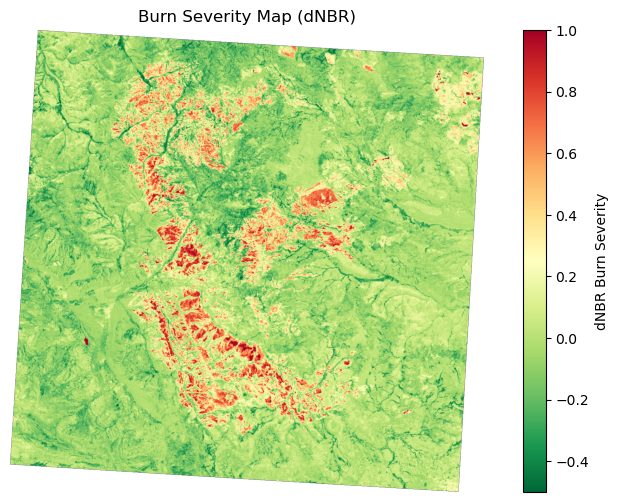

In [7]:
# Extract NIR (band 5) and SWIR2 (band 7)
nir_pre = prefire.sel(band=5).data.astype('float32')
swir_pre = prefire.sel(band=7).data.astype('float32')
nir_post = postfire.sel(band=5).data.astype('float32')
swir_post = postfire.sel(band=7).data.astype('float32')

# Calculate NBR
nbr_pre = (nir_pre - swir_pre) / (nir_pre + swir_pre)
nbr_post = (nir_post - swir_post) / (nir_post + swir_post)
nbr_pre[np.isinf(nbr_pre)] = np.nan
nbr_post[np.isinf(nbr_post)] = np.nan

# dNBR
dnbr = nbr_pre - nbr_post

# Save dNBR locally
dnbr_file = "dnbr.tif"
with rasterio.open(
    dnbr_file,
    'w',
    driver='GTiff',
    height=dnbr.shape[0],
    width=dnbr.shape[1],
    count=1,
    dtype='float32',
    crs=prefire.rio.crs,
    transform=prefire.rio.transform()
) as dst:
    dst.write(dnbr, 1)

# Quick visualization
plt.figure(figsize=(10,6))
plt.imshow(np.ma.masked_invalid(dnbr), cmap='RdYlGn_r', vmin=-0.5, vmax=1)
plt.colorbar(label='dNBR Burn Severity')
plt.title("Burn Severity Map (dNBR)")
plt.axis('off')
plt.show()


## 🗺️ Step 5. Act by Creating your own map to share the story

We can can classify our dNBR values into different burn severity levels to help with postfire assessment. Use the following codeblocks to classify the dNBR ouput and visualize these findings on an interactive map that can be shared with others.

How might you use this map to share the story about the Pack Trail fire? What additional data would you want to add to this map?

In [8]:
# Read the raster
raster_path = 'dnbr.tif'
with rasterio.open(raster_path) as src:
    data = src.read(1).astype('float32')
    nodata = src.nodata
    data[data == nodata] = np.nan

# Define classification intervals matching EE script
intervals = [-np.inf, -0.251, -0.100, 0.100, 0.270, 0.440, 0.660, 2.000, np.inf]

# Classify raster data into classes 0 to 7
classified = np.digitize(data, intervals) - 1

# Assign NoData pixels to class 8
nodata_class = 8
classified[np.isnan(data)] = nodata_class

# Define colormap including a color for NoData (white)
colormap = [
    "#ffffff",  # 0 - Below -0.251 (background)
    "#7a8737",  # 1 - Enhanced Regrowth, High (-0.251 to -0.100)
    "#acbe4d",  # 2 - Enhanced Regrowth, Low (-0.100 to 0.100)
    "#0ae042",  # 3 - Unburned (0.100 to 0.270)
    "#fff70b",  # 4 - Low Severity (0.270 to 0.440)
    "#ffaf38",  # 5 - Moderate-low Severity (0.440 to 0.660)
    "#ff641b",  # 6 - Moderate-high Severity (0.660 to 2.000)
    "#a41fd6",  # 7 - High Severity (> 2.000)
    "#000000"   # 8 - No Data
]

# Save the classified raster
classified_path = "dnbr_ee_classified.tif"

if os.path.exists(classified_path):
    os.remove(classified_path)

with rasterio.open(
    classified_path,
    "w",
    driver="GTiff",
    height=classified.shape[0],
    width=classified.shape[1],
    count=1,
    dtype="uint8",
    crs=src.crs,
    transform=src.transform,
    compress="lzw"
) as dst:
    dst.write(classified.astype('uint8'), 1)


In [9]:
# Create LeafMap instance
m = leafmap.Map(center=[38.5, -121.0], zoom=8)
m.add_basemap("Esri.WorldImagery")

# Add the classified raster with discrete colormap
m.add_raster(classified_path, layer_name="dNBR Burn Severity (EE Style)", colormap=colormap)

# Add legend labels matching classes
labels = [
    "Below -0.251",
    "Enhanced Regrowth, High (-0.251 to -0.100)",
    "Enhanced Regrowth, Low (-0.100 to 0.100)",
    "Unburned (0.100 to 0.270)",
    "Low Severity (0.270 to 0.440)",
    "Moderate-low Severity (0.440 to 0.660)",
    "Moderate-high Severity (0.660 to 2.000)",
    "High Severity (> 2.000)",
    "No Data"
]

m.add_legend(
    title="dNBR Burn Severity Classes",
    labels=labels,
    colors=colormap,
    location="bottomleft"
)

# Display the map
m

Map(center=[43.592339499999994, -110.0820925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

## ⛰️ (OPTIONAL) Step 6. Extend this exercise with a 3D visualization

MapLibre GL offers additional opportunities to plot and visualize geospatial data with 3D capabilities. Use the following code to see the dNBR layer on a 3D surface.

What new insights can you gather from this visualization?

In [ ]:
# import rioxarray

# # Load the dnbr.tif to inspect its properties
# dnbr_xarray = rioxarray.open_rasterio('dnbr.tif')

# print("dNBR CRS:", dnbr_xarray.rio.crs)
# print("dNBR Bounds:", dnbr_xarray.rio.bounds())

# # Calculate approximate center from bounds for potential map adjustment
# minx, miny, maxx, maxy = dnbr_xarray.rio.bounds()
# center_x = (minx + maxx) / 2
# center_y = (miny + maxy) / 2
# print(f"Approximate Center (original CRS): ({center_x:.2f}, {center_y:.2f})")

In [ ]:
# import rioxarray

# # Load the original dnbr.tif
# dnbr_xarray = rioxarray.open_rasterio('dnbr.tif')

# # Reproject to EPSG:4326 (WGS84) for better compatibility with web maps
# dnbr_reprojected = dnbr_xarray.rio.reproject("EPSG:4326")

# # Save the reprojected raster
# dnbr_reprojected_file = "dnbr_reprojected.tif"
# dnbr_reprojected.rio.to_raster(dnbr_reprojected_file)

# print(f"Reprojected dNBR saved to: {dnbr_reprojected_file}")
# print("Reprojected dNBR CRS:", dnbr_reprojected.rio.crs)
# print("Reprojected dNBR Bounds:", dnbr_reprojected.rio.bounds())

# # Calculate the new center for the map
# minx_proj, miny_proj, maxx_proj, maxy_proj = dnbr_reprojected.rio.bounds()
# center_lon = (minx_proj + maxx_proj) / 2
# center_lat = (miny_proj + maxy_proj) / 2
# print(f"Approximate Center (reprojected CRS): ({center_lon:.2f}, {center_lat:.2f})")

In [ ]:
# import leafmap.maplibregl as leafmap
# import geopandas as gpd 

# # Retrieve the previously defined colormap and labels
# # colormap = ['#ffffff', '#7a8737', '#acbe4d', '#0ae042', '#fff70b', '#ffaf38', '#ff641b', '#a41fd6', '#ffffff']
# # labels = [
# #     "Below -0.251",
# #     "Enhanced Regrowth, High (-0.251 to -0.100)",
# #     "Enhanced Regrowth, Low (-0.100 to 0.100)",
# #     "Unburned (0.100 to 0.270)",
# #     "Low Severity (0.270 to 0.440)",
# #     "Moderate-low Severity (0.440 to 0.660)",
# #     "Moderate-high Severity (0.660 to 2.000)",
# #     "High Severity (> 2.000)",
# #     "No Data"
# # ]

# # Define the path to the reprojected dNBR file
# dnbr_reprojected_file = "dnbr_reprojected.tif"

# # Load the reprojected dNBR file to get its bounds and calculate the center
# import rioxarray
# dnbr_reprojected_xarray = rioxarray.open_rasterio(dnbr_reprojected_file)
# minx_proj, miny_proj, maxx_proj, maxy_proj = dnbr_reprojected_xarray.rio.bounds()
# center_lon = (minx_proj + maxx_proj) / 2
# center_lat = (miny_proj + maxy_proj) / 2

# # Create MapLibre GL map with the calculated center
# m = leafmap.Map(center=[center_lon, center_lat], zoom=8, pitch=60, bearing=0, exaggeration=1.5)

# # Add basemap for context
# m.add_basemap('Esri.WorldTerrain')

# # Add the reprojected dnbr.tif raster layer
# m.add_raster(
#     dnbr_reprojected_file,
#     layer_name="dNBR Burn Severity (3D)",
#     colormap=colormap, # Reusing the colormap from previous steps
#     vmin=-0.5, # Adjust visualization range as needed
#     vmax=1,
#     # colormap can also be a string like 'RdYlGn_r' for continuous data
#     # but here we use the custom discrete colormap
# )

# # Add legend with the custom labels and colors
# m.add_legend(
#     title="dNBR Burn Severity Classes",
#     labels=labels, # Reusing the labels from previous steps
#     colors=colormap,
#     location="bottomleft"
# )

# # Display the map
# m